In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Limit memory growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [36]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)
train_labels = np.expand_dims(train_labels, -1)
test_labels = np.expand_dims(test_labels, -1)
total_images = np.vstack((train_images, test_images))
total_labels = np.vstack((train_labels, test_labels))

In [35]:
total_labels.shape

(70000, 1)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [48]:
total_dataset = tf.data.Dataset.from_tensor_slices((total_images))

In [44]:
train_ds = train_dataset.as_numpy_iterator()

## 2. Visualize Data and Build Dataset

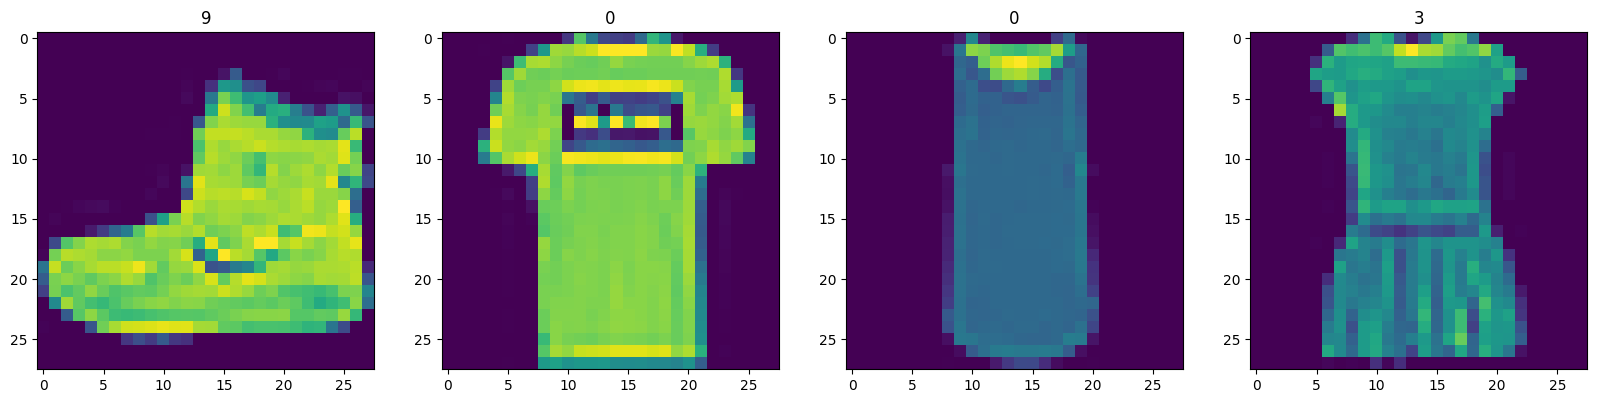

In [45]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))

for i in range(4):
    sample = train_ds.next()
    ax[i].imshow(np.squeeze(sample[0]))
    ax[i].set_title(sample[1])

In [53]:
# Scale and return images only
def scale_images(image):
    return image/255

In [54]:
ds = total_dataset.map(scale_images).cache().shuffle(60000).batch(128).prefetch(64)

In [55]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build Neural Network

### 3.1 Import Modeling Components

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [12]:
def build_generator():
    model = Sequential([
        # Pass in 128 random values, then give the 7 x 7 to give spacial qualities to have enough
        # space to make an image - beginnings of a generated image
        Dense(7*7*128, input_dim = 128),
        LeakyReLU(0.2),
        Reshape((7,7,128)),

        # UpSampling Block to expand the image
        UpSampling2D(),
        Conv2D(128, 5, padding = "same"),
        LeakyReLU(0.2),

        UpSampling2D(),
        Conv2D(128, 5, padding = "same"),
        LeakyReLU(0.2),

        # Convolutional Blocks to learn more
        Conv2D(128, 4, padding = "same"),
        LeakyReLU(0.2),

        Conv2D(128, 4, padding = "same"),
        LeakyReLU(0.2),

        # Conv Layers to get to one channel
        Conv2D(1, 4 , padding = "same", activation = "sigmoid")
    ])

    return model

In [77]:
generator = build_generator()

In [78]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 75ms/step


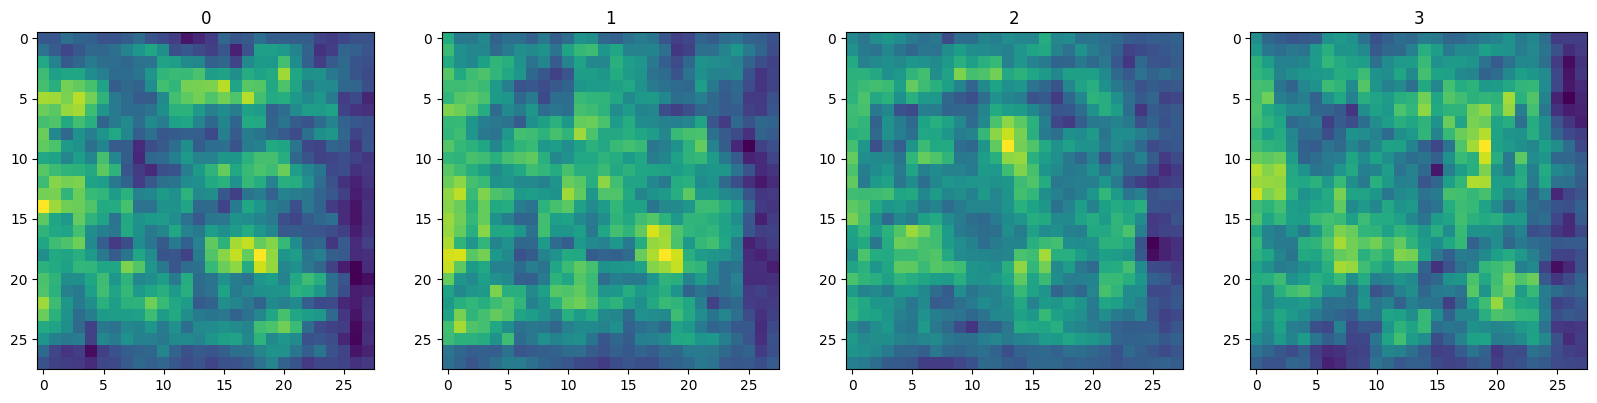

In [79]:
images = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize = (20,20))

for idx, img in enumerate(images):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].set_title(idx)

### 3.3 Build Discriminator

In [80]:
def build_discriminator():
    model = Sequential([
        Conv2D(32, 5, input_shape = (28,28,1)),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(64, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(128, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(256, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Flatten(),
        Dropout(0.4),

        Dense(1, activation = "sigmoid")
        ])

    return model

In [81]:
discriminator = build_discriminator()

In [82]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)      

In [83]:
discriminator.predict(images)

1/1 [==============================] - 0s 60ms/step


array([[0.49990454],
       [0.49970108],
       [0.49985346],
       [0.49987224]], dtype=float32)

## 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [84]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [85]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [86]:
from tensorflow.keras.models import Model

In [87]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator
            y_hat_real = self.discriminator(real_images, training = True)
            y_hat_fake = self.discriminator(fake_images, training = True)
            y_hat_realfake = tf.concat([y_hat_real, y_hat_fake], axis = 0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(y_hat_real), tf.ones_like(y_hat_fake)], axis = 0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(y_hat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(y_hat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis = 0)

            # Calculate loss - BINARYCROSSENTROPY
            total_d_loss = self.d_loss(y_realfake, y_hat_realfake)

        # Apply backpropagation - nn Learn
        d_gradients = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Training the Generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training = True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training = False)
        
            # Calculate the loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        # Apply backpropagation
        g_gradients = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss" : total_g_loss}

In [88]:
fashion_gan = FashionGAN(generator, discriminator)

In [89]:
fashion_gan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [90]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [91]:
class ModelMonitor(Callback):
    def __init__(self, num_img = 3, latent_dim = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join("images", f"generated_img_{epoch}_{i}.png"))

### 4.4 Train

In [92]:
# Recommend 2000 Epochs
hist = fashion_gan.fit(ds, epochs=20, callbacks = [ModelMonitor()])

Epoch 1/20


547/547 [==============================] - 93s 169ms/step - d_loss: 0.4830 - g_loss: 1.5119
Epoch 2/20
547/547 [==============================] - 92s 167ms/step - d_loss: 0.5338 - g_loss: 3.3820
Epoch 3/20
547/547 [==============================] - 84s 153ms/step - d_loss: 0.5995 - g_loss: 0.7130
Epoch 4/20
547/547 [==============================] - 96s 175ms/step - d_loss: 0.3875 - g_loss: 0.1387
Epoch 5/20
547/547 [==============================] - 94s 172ms/step - d_loss: 0.3377 - g_loss: 0.0313
Epoch 6/20
547/547 [==============================] - 85s 155ms/step - d_loss: 0.7480 - g_loss: 0.4888
Epoch 7/20
547/547 [==============================] - 96s 175ms/step - d_loss: 0.6844 - g_loss: 0.6360
Epoch 8/20
547/547 [==============================] - 93s 170ms/step - d_loss: 0.6995 - g_loss: 0.6356
Epoch 9/20
547/547 [==============================] - 94s 171ms/step - d_loss: 0.6881 - g_loss: 0.6420
Epoch 10/20
547/547 [==============================] - 92s 168ms/step - d_loss: 0.69

### 4.5 Review Performance

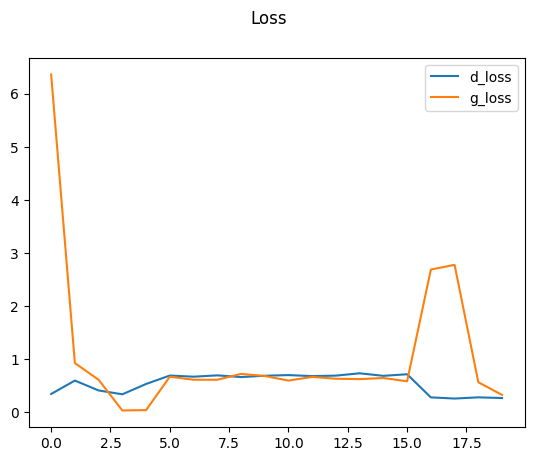

In [93]:
plt.suptitle("Loss")
plt.plot(hist.history["d_loss"], label = "d_loss")
plt.plot(hist.history["g_loss"], label = "g_loss")
plt.legend()
plt.show()

## 5. Test out the Generator

### 5.1 Generate Images

In [106]:
imgs = generator.predict(tf.random.normal((16,128,1)))

ValueError: in user code:

    File "c:\Users\Sriram Kidambi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Sriram Kidambi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Sriram Kidambi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Sriram Kidambi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\Sriram Kidambi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Sriram Kidambi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_36" is incompatible with the layer: expected shape=(None, 256, 1), found shape=(None, 128, 1)


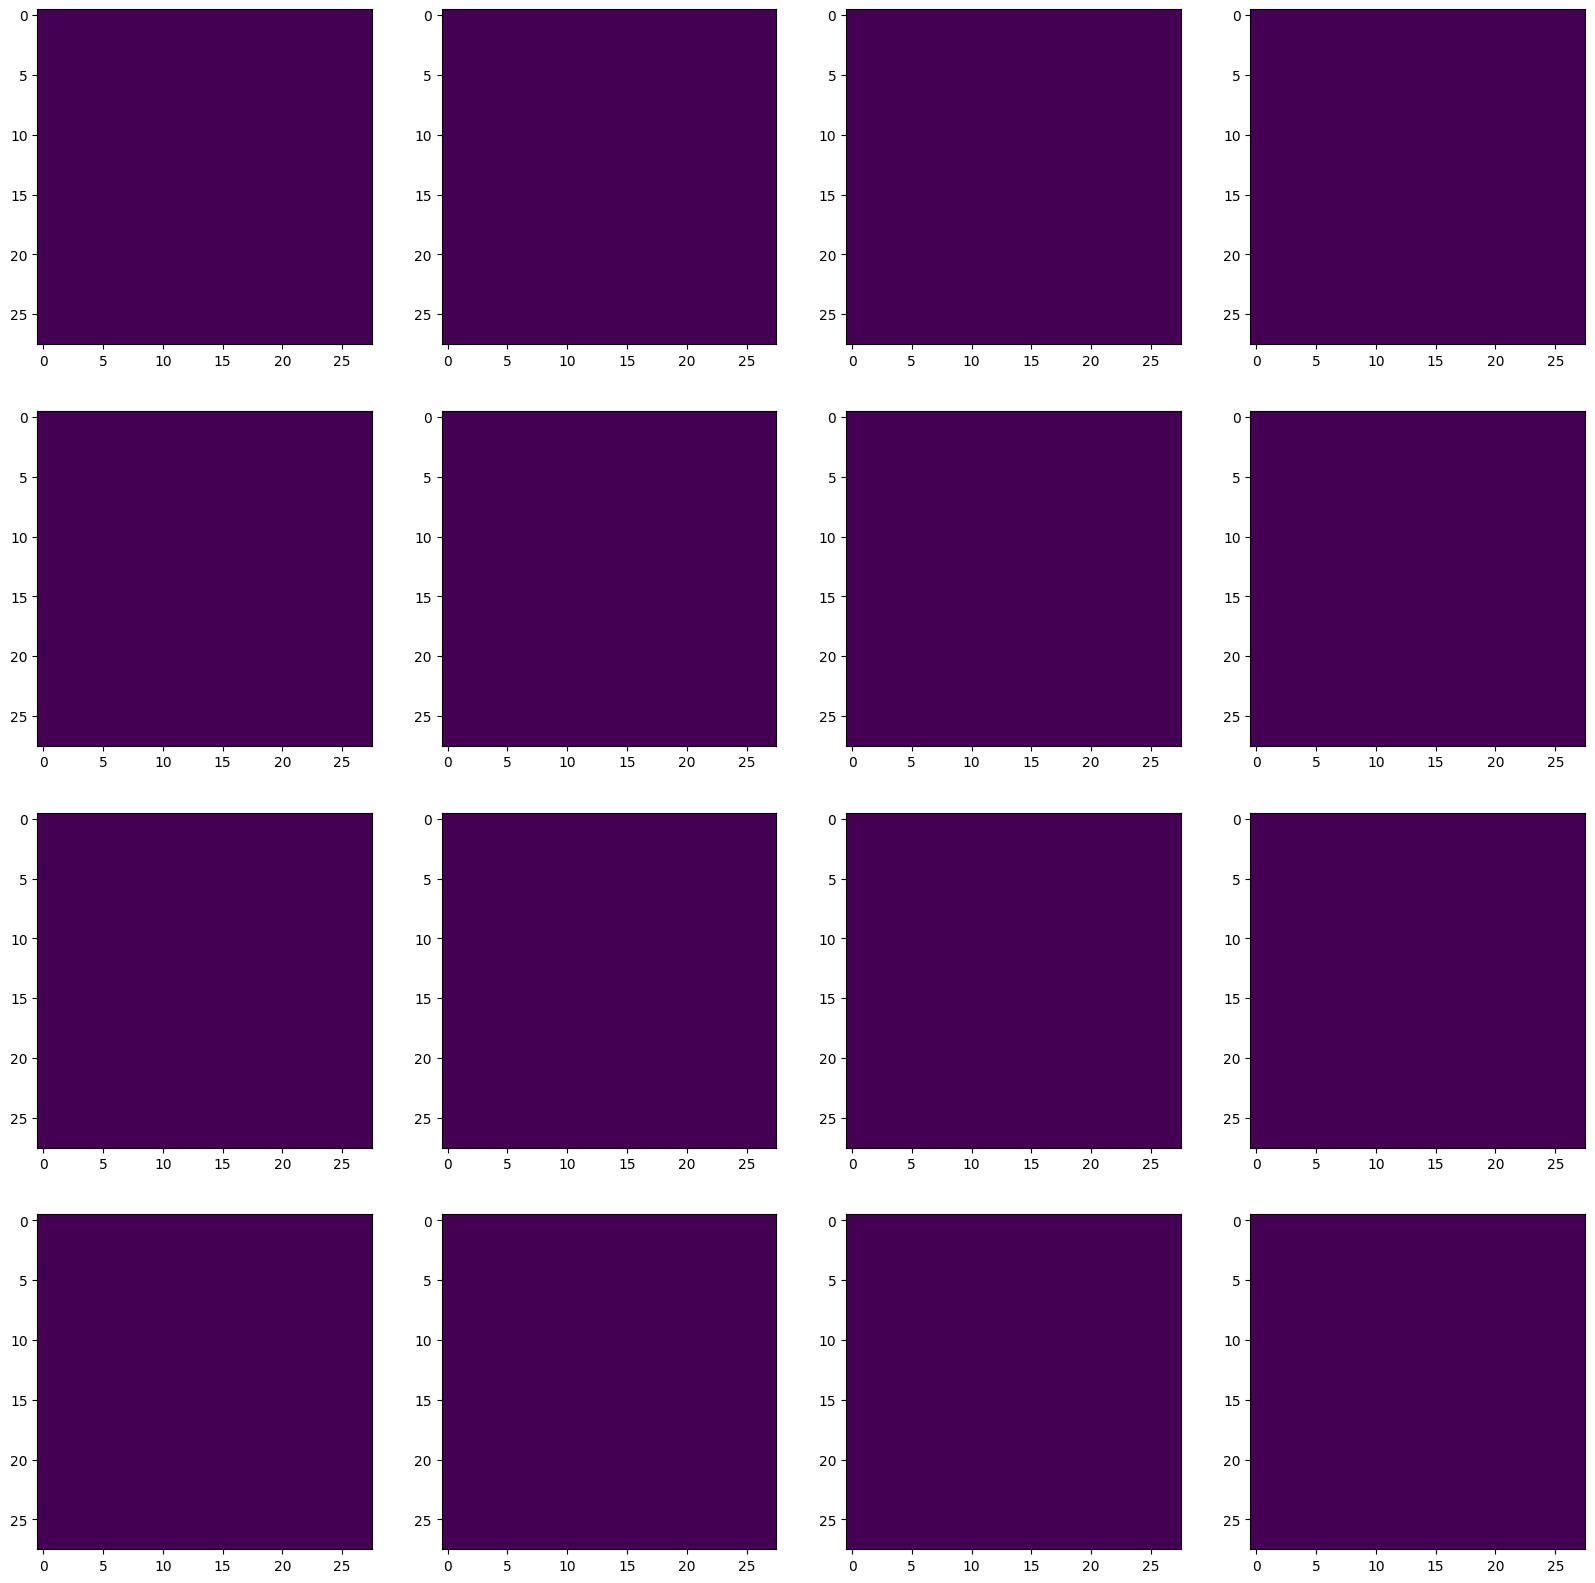

In [96]:
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize = (20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])